In [10]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.attn_features_artifact import AttentionFeaturesArtifact
from math import sqrt
from torch import Tensor
from text3d2video.attention_visualization import split_heads

from einops import rearrange

artifact_tag = "attn_data:latest"
attn_data = AttentionFeaturesArtifact.from_wandb_artifact_tag(
    artifact_tag, download=True
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wandb: Downloading large artifact attn_data:latest, 4408.84MB. 325 files... 
wandb:   325 of 325 files downloaded.  
Done. 0:0:2.1


In [12]:
# read data
multidict = attn_data.get_features_diskdict()
images = attn_data.get_images()
layer_names = sorted(multidict.key_values("layer"))
time_steps = sorted(multidict.key_values("timestep"))

for layer in layer_names:
    print(layer)

down_blocks.0.attentions.0.transformer_blocks.0.attn1
down_blocks.0.attentions.1.transformer_blocks.0.attn1
down_blocks.1.attentions.0.transformer_blocks.0.attn1
down_blocks.1.attentions.1.transformer_blocks.0.attn1
down_blocks.2.attentions.0.transformer_blocks.0.attn1
down_blocks.2.attentions.1.transformer_blocks.0.attn1
mid_block.attentions.0.transformer_blocks.0.attn1
up_blocks.1.attentions.0.transformer_blocks.0.attn1
up_blocks.1.attentions.1.transformer_blocks.0.attn1
up_blocks.1.attentions.2.transformer_blocks.0.attn1
up_blocks.2.attentions.0.transformer_blocks.0.attn1
up_blocks.2.attentions.1.transformer_blocks.0.attn1
up_blocks.2.attentions.2.transformer_blocks.0.attn1
up_blocks.3.attentions.0.transformer_blocks.0.attn1
up_blocks.3.attentions.1.transformer_blocks.0.attn1
up_blocks.3.attentions.2.transformer_blocks.0.attn1


In [5]:
layer_name = layer_names[0]
time_step = time_steps[-1]

identifier = {"layer": layer_name, "timestep": time_step}

print(identifier)

# get queries keys and values
x = multidict[identifier | {"name": "x"}][: len(images)]
qrys = multidict[identifier | {"name": "query"}][: len(images)]
keys = multidict[identifier | {"name": "key"}][: len(images)]
vals = multidict[identifier | {"name": "value"}][: len(images)]

layer_res = int(sqrt(qrys.shape[1]))

# reshape q/k/v to b t h w d
qrys_multihead = split_heads(qrys)
keys_multihead = split_heads(keys)
vals_multihead = split_heads(vals)

{'layer': 'down_blocks.0.attentions.0.transformer_blocks.0.attn1', 'timestep': '9'}


/home/jorge/thesis/text3d2video/disk_multidict.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return self.deserialization_fun(path)


Ellipsis

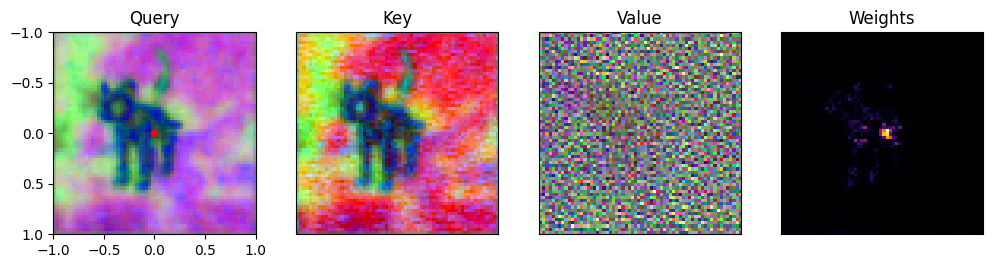

In [9]:
from text3d2video.attention_visualization import (
    compute_sdp_attn_weights,
    plot_mpl_qkv_weights,
    reshape_kv_weights,
)

from text3d2video.util import sample_feature_map

head_idx = 0
frame_idx = 1

pixel_coord = Tensor([0,0])

# get query, key, value for head
head_qrys = qrys_multihead[:, :, head_idx, :]
head_keys = keys_multihead[:, :, head_idx, :]
head_vals = vals_multihead[:, :, head_idx, :]

# reshape query
q_square = rearrange(head_qrys[frame_idx], "(h w) d -> d h w", h=layer_res)

# get query feature
pixel_qry = sample_feature_map(q_square, pixel_coord.unsqueeze(0), mode="nearest")[0]

# compute attention weights
weights = compute_sdp_attn_weights(pixel_qry, head_keys[frame_idx], temperature=1)

def reshape_concatenated(seq: Tensor):
    return rearrange(seq, "(n h w) d -> d h (n w)", w=layer_res, h=layer_res)

# reshape weights, keys, values
k_square, v_square, weights_square = reshape_kv_weights(
    head_keys[frame_idx], head_vals[frame_idx], weights, reshape_concatenated
)

plot_mpl_qkv_weights(
    q_square,
    k_square,
    v_square,
    weights_square,
    pixel_coord,
)
...